In [1]:
from ast import mod
import torch
from torch.nn import Module, Linear, Conv2d, MaxPool2d, LeakyReLU, Sequential, BatchNorm2d, Sigmoid, ConvTranspose2d
from torch import nn


def create_conv_module(in_channels, out_channels, kernel_size=3, stride=2):
    module = Sequential(
        Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=1, bias=False),
        BatchNorm2d(num_features=out_channels),
        LeakyReLU()
    )
    return module 

def create_trans_conv_module(in_channels, out_channels, kernel_size=3, stride=1, padding=0):
    module = Sequential(
        ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False),
        BatchNorm2d(num_features=out_channels),
        LeakyReLU()
    )
    return module        

class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.sequential = Sequential(
            create_conv_module(in_channels=1, out_channels=4, kernel_size=4),
            create_conv_module(in_channels=4, out_channels=8, kernel_size=3), 
            create_conv_module(in_channels=8, out_channels=16, kernel_size=3), 
            Conv2d(in_channels=16, out_channels=1, kernel_size=4, stride=1), 
            Sigmoid()
        )

    def forward(self, x):
        return self.sequential(x).view(-1)

class Generator(Module):

    def __init__(self, in_channels=64) -> None:
        super().__init__()
        self.sequential = Sequential(
            create_trans_conv_module(in_channels=100, out_channels=128, kernel_size=4),
            create_trans_conv_module(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1),
            create_trans_conv_module(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=4, bias=False, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.sequential(x)        


/home/daniel/mambaforge/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import PILToTensor, ConvertImageDtype, Compose

img_transforms = Compose([
    PILToTensor(),
    ConvertImageDtype(torch.float)
])

root_dir = './data/mnist/'
train_dataset = MNIST(root=root_dir+'train', train=True, download=True, transform=img_transforms)
test_dataset = MNIST(root=root_dir+'test', train=False, download=True, transform=img_transforms)


batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=20)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=20)


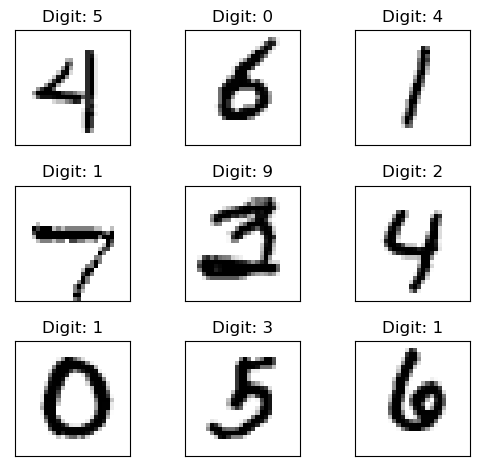

In [3]:
#show some images
import matplotlib.pyplot as plt
import numpy as np
batch_imgs, batch_labels = next(iter(train_loader))
plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(batch_imgs[i].view(28,28), cmap='binary', interpolation='none')
    plt.title("Digit: {}".format(train_dataset[i][1]))
    plt.xticks([])
    plt.yticks([])


In [4]:
def sample_from_latent(n_samples):
    return torch.randn(size=(n_samples, 100, 1, 1))

#### Train Deep Convolutional GAN on MNIST

* Instantiate the generator and discriminator
* Create the optimizers
* Create the loss functions
* Iterate over the batches of the dataloarder
* Update the weights (optimizer step)
* Compute the losses and generate images

In [8]:
from tqdm.auto import tqdm


generator = Generator()
discriminator = Discriminator()


def compute_loss(pred, target):
    return torch.nn.functional.binary_cross_entropy(pred, target)  

def do_train(epochs = 10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    losses = []
    
    discriminator.to(device)
    generator.to(device)
    
    optimizer_G = torch.optim.Adam(generator.parameters())
    optimizer_D = torch.optim.Adam(discriminator.parameters())

    progress_bar = tqdm(range(epochs*len(train_loader)))

    for epoch in range(epochs):
        discriminator.train()
        for img_batch, labels_batch in train_loader:
            optimizer_D.zero_grad()
            
            ones = torch.ones(labels_batch.shape).to(device)
            zeros = torch.zeros(labels_batch.shape).to(device)
            z_input = sample_from_latent(img_batch.shape[0]).to(device)

            img_batch = img_batch.to(device)
            fake_imgs = generator(z_input).detach()

            y_pred = discriminator(img_batch)
            y_pred_fake = discriminator(fake_imgs)

            loss = compute_loss(y_pred, ones)
            loss += compute_loss(y_pred_fake, zeros)
            loss.backward()

            losses.append(loss.cpu().item())
            optimizer_D.step()
            progress_bar.update(1)
    return losses        
 


In [9]:
losses = do_train(2)

100%|██████████| 3750/3750 [00:21<00:00, 175.29it/s]


Text(0, 0.5, 'Loss')

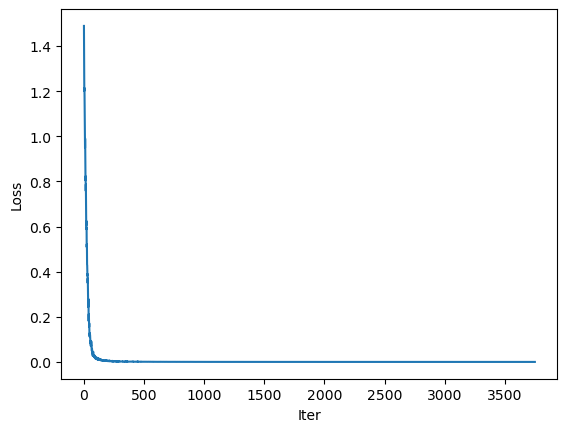

In [11]:
#plot losses
plt.plot(losses)
plt.xlabel('Iter')
plt.ylabel('Loss')


0.9999905749618847